In [9]:
#Sent by James on 02/06/2018. 
#Code designed to analyse and plot MC-ember experiments

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
from scipy import interpolate
from numpy import pi
# import mpld3
import seaborn as sns
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
from scipy.optimize import curve_fit

from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
Colors = sns.color_palette()
import seaborn as sns
mpl.rcParams['font.serif'] = 'Times New Roman'
import matplotlib.ticker as mtick



def get_log(X,y,X_plt):
    XX = X[:, np.newaxis]
    clf = linear_model.LogisticRegression(C=1e5)
    clf.fit(XX,y)
    loss = model(X_plt * clf.coef_ + clf.intercept_).ravel()
    return loss

def model(x):
    return 1 / (1 + np.exp(-x))
def get_mmm(x_ref,y_ref):
    Mean= x_ref[(y_ref<.55)&(y_ref>.45)].mean()
    Min = x_ref[(y_ref<.20)].min()
    Max = x_ref[(y_ref>.80)].max()
    return Min, Max, Mean
sns.set_style("whitegrid", {'axes.grid' : False});   sns.set_style("ticks")
mpl.rcParams["font.family"] = "serif"

mpl.rc("savefig", dpi=500)

In [10]:
def xlsx_2_pds(xlsx_filename):
    xlsxfile = pd.ExcelFile(xlsx_filename)
    data = xlsxfile.parse('Test Data', index_col = 'Test ID')
    RD = data[['PartMat','Fuel','HeatDur',"WS",'Diam',"Length",'MC','FBMass',"Result","Flags","TunnelHum","TunnelTemp"]];
    RD.loc[:,"ResBin"] = pd.Series((RD.Result == "SI")*1,index=RD.index)
    RD = RD[RD.Diam.isnull()==False]         ## Deleting blank entries
    RD = RD[RD.FBMass.isnull()==False]       ## Deleting blank entries
    RD = RD[RD.MC.isnull()==False]           ## Deleting blank entries
    RD = RD[RD.Flags.isnull()==True]         ## Deleting blank entries
    RD = RD[RD.Result.isnull()==False]       ## Deleting blank entries
#     RD = RD[RD.ResultLength.isin(np.array([1.1,6.5]))]
#     RD = RD[(RD.Length == 1.1)|(RD.Length == 6.5)]
#     RD = RD[(RD.Length == 1.1)|(RD.Length == 6.5)]%%!
    RD = RD[(RD.FBMass < 110)&(RD.FBMass > 85)]       ## Removing aberrant fuel masses
    RD = RD[RD.Fuel.isin(['Sawdust'])]                ## Only using Sawdust
    RD = RD[RD.HeatDur.isin(['45/10','15/10','FiveFive','FifteenTen','TwentyTen',
                             'ThreeFive','OneFive','TwoFive',' 12/10',' 15/10'])]   ## Only using some of the heating times
#     RD = RD[RD.Flags.isin(["split"])==False]
    return RD

# RD = xlsx_2_pds(r"C:\Users\Urban_000\Dropbox\IPython Notebooks\EmbersRelated\Smolder\2016_MC_raw_Data_Embers JLU.xlsx")
# RD = xlsx_2_pds(r"C:\Users\urban\Dropbox\Embers Raw Data\2016_MC_raw_Data_Embers JLU Fall16.xlsx") #2016_MC_raw_Data_Embers JLU Fall16 (embers lab's conflicted copy 2016-09-20)
RD = xlsx_2_pds(r"C:\Users\urban\Dropbox\Embers Raw Data\2016_MC_raw_Data_Embers JLU Fall16 (embers lab's conflicted copy 2016-09-20).xlsx")
RD['FMC'] = RD['MC'].map(lambda x: x*100.)

IOError: [Errno 2] No such file or directory: "C:\\Users\\urban\\Dropbox\\Embers Raw Data\\2016_MC_raw_Data_Embers JLU Fall16 (embers lab's conflicted copy 2016-09-20).xlsx"

In [45]:
from sklearn import linear_model

class log_reg:
    """ This a wrapper around scikit-learn's logistic regression"""
    def __init__(self,x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
        # perform fit
        XX = self.x_data[:, np.newaxis]
        clf = linear_model.LogisticRegression(C=1e5)
        clf.fit(XX,self.y_data)
        
        self.intercept_ = clf.intercept_
        self.coef_ = clf.coef_ 
        
    def get_p(self,x_plt):
        return model(x_plt* self.coef_ + self.intercept_).ravel()
        
    def get_x_at_p(self,p_):
        return (np.log(1./p_-1.)+self.intercept_)/-self.coef_
    
    def model(self, x):
        return 1. / (1. + np.exp(-x))
    
    def get_errorbar(self):
        Mean= self.get_x_at_p(.5)
        Min = self.get_x_at_p(.025)
        Max = self.get_x_at_p(.975)
        return np.array([Mean, Min, Max])

# derp = log_reg(RD[BOOL].Temperature.values,
#                RD[BOOL].FI.values)

In [44]:
RD.Diam.unique()

array([  9.5  ,   6.35 ,   4.8  ,  11.   ,  12.7  ,   3.175,   1.59 ,
         3.18 ])

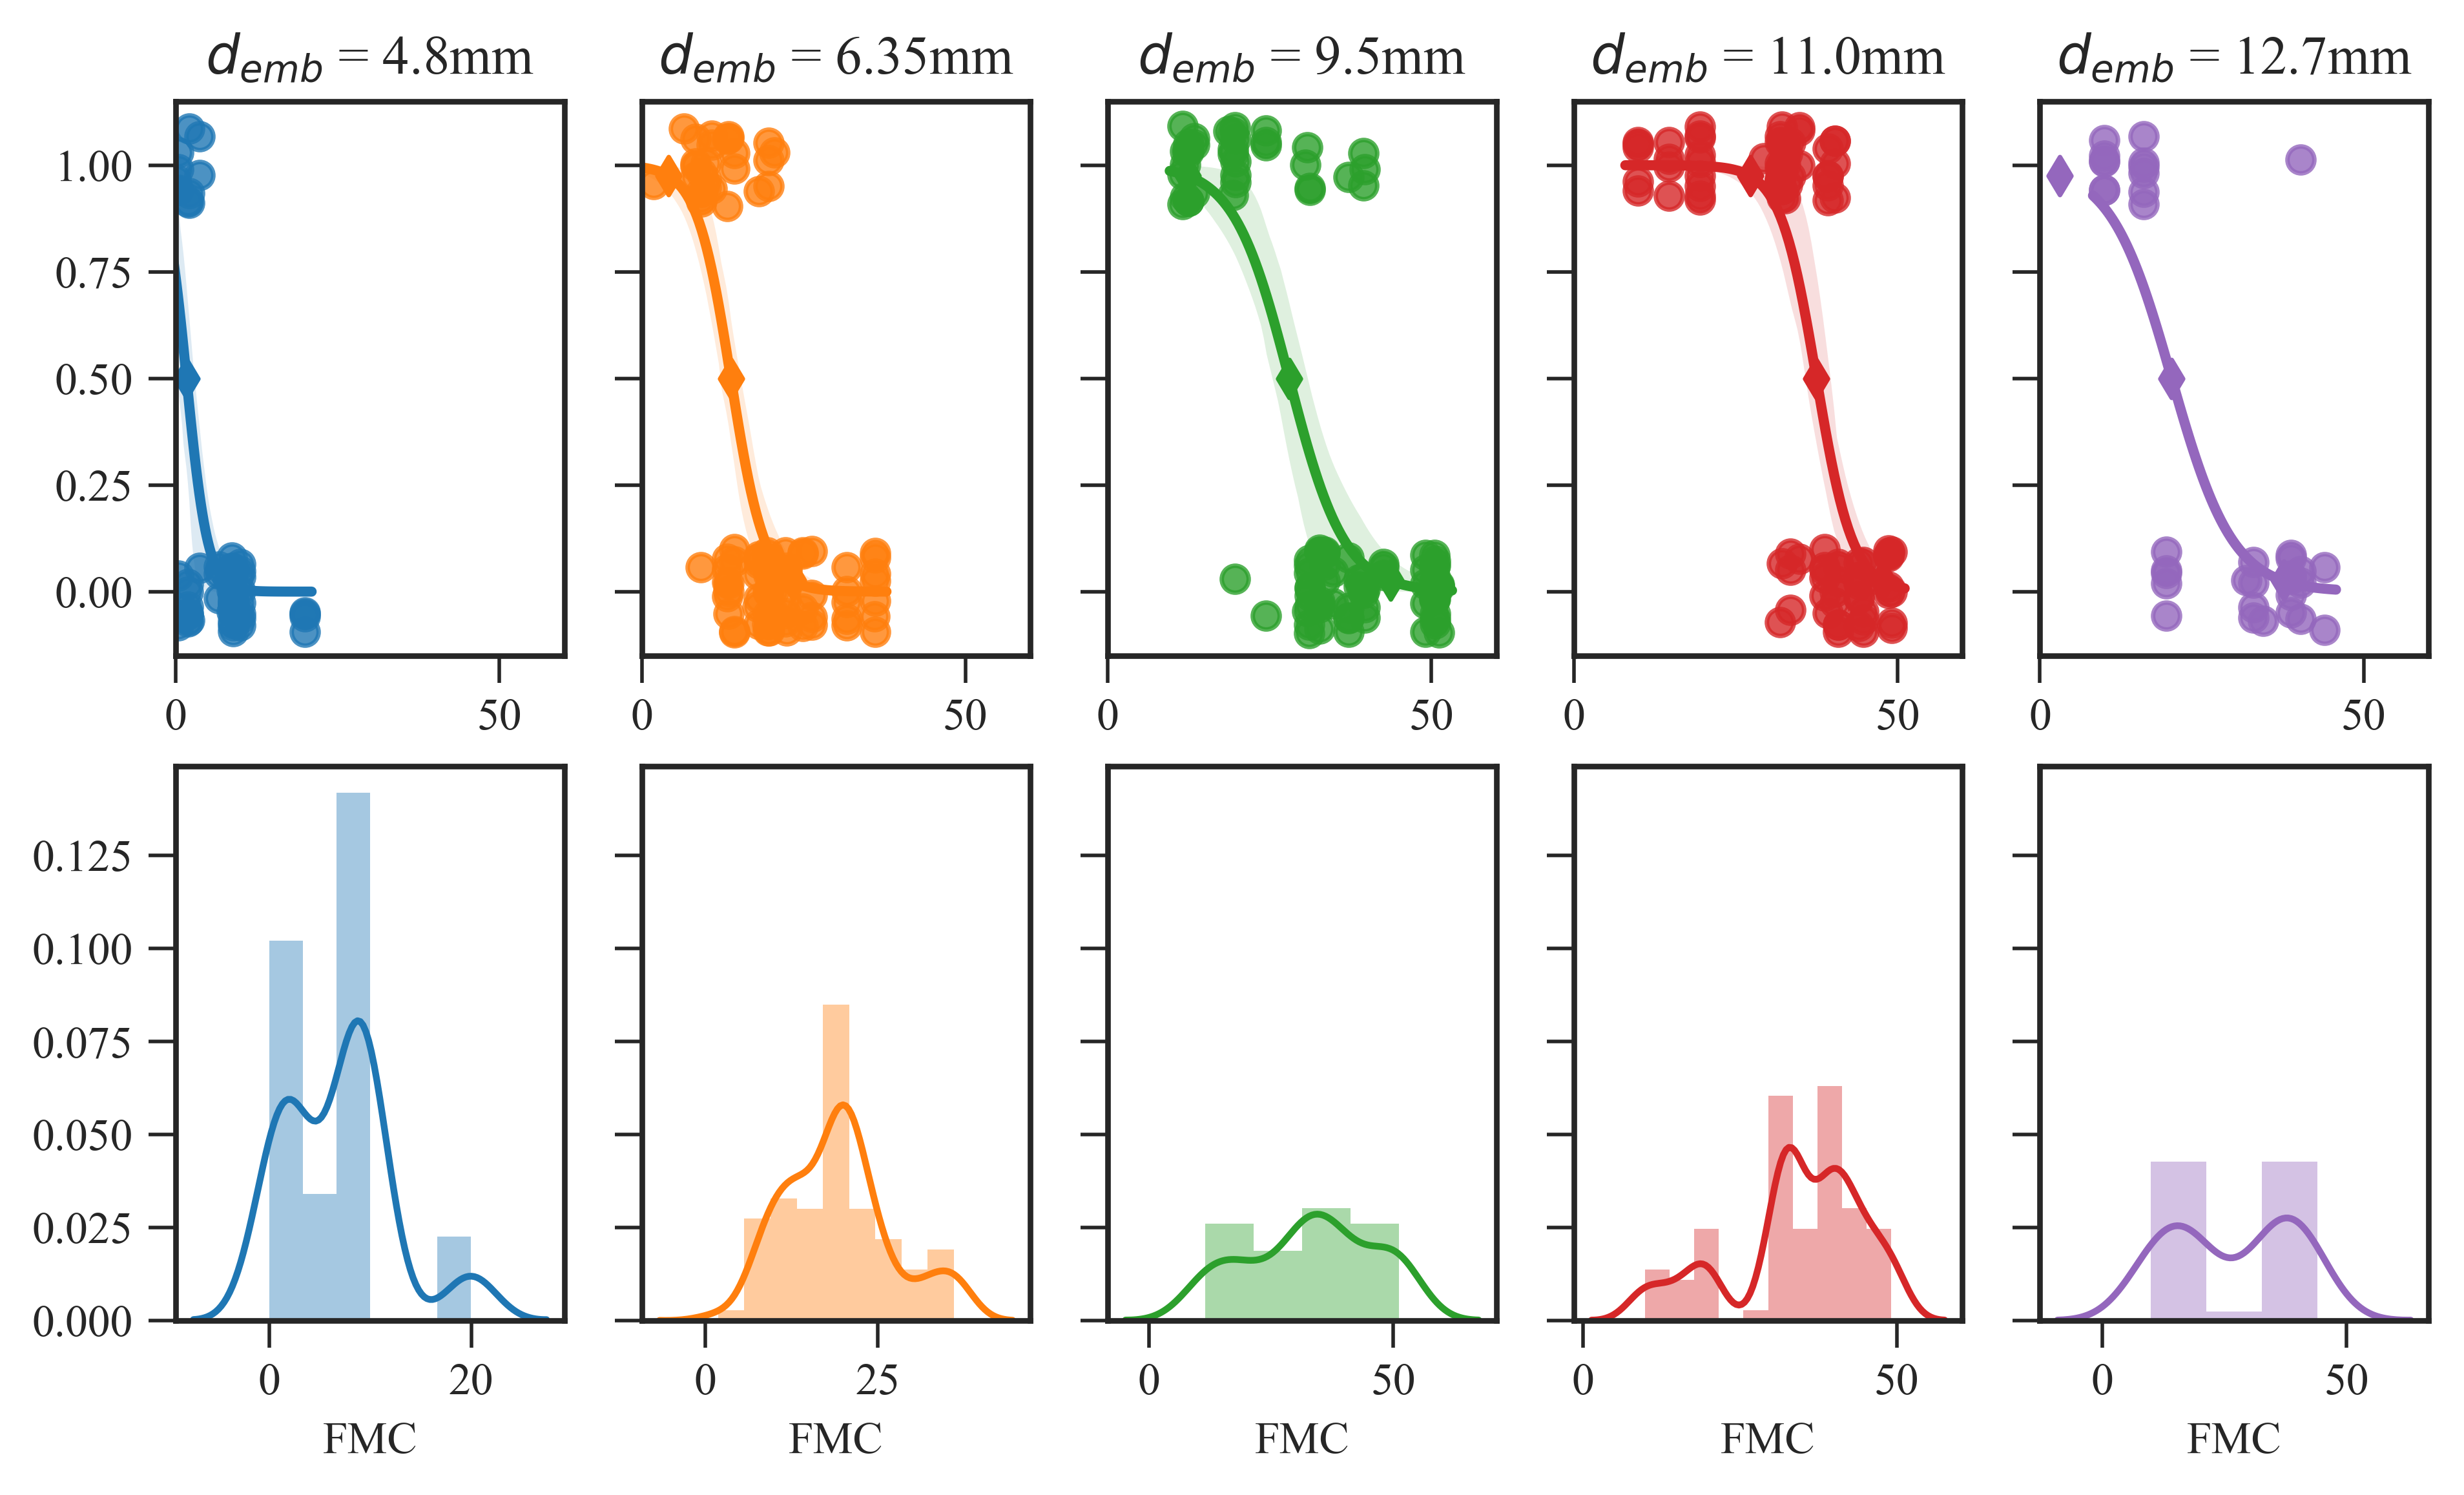

In [81]:
emb_diams = np.array([4.8,6.35,9.5,11.,12.7])
fig, ax = plt.subplots(ncols = 5, nrows=2, sharey='row', sharex=False)
MC_bnd = np.zeros((len(emb_diams),3))
error_lvls = np.array([.5,.0275,.975])
fig.set_size_inches((9,5))
for i, d_emb in enumerate(emb_diams):
    BOOL = (RD.Diam == d_emb)&(RD.WS == 0.5)
    sns.distplot(RD[BOOL].FMC,ax = ax[1,i],color = 'C'+str(i))
    sns.regplot(x=RD[BOOL]["FMC"].values, 
                y=RD[BOOL]["ResBin"].values,
                y_jitter=.1, logistic=True, ax = ax[0,i], color='C'+str(i), n_boot=100)
    log_fit = log_reg(RD[BOOL]["FMC"].values,
                      RD[BOOL]["ResBin"].values)
    MC_bnd[i] =  log_fit.get_errorbar()[:,0,0]
    ax[0,i].scatter(log_fit.get_errorbar(), error_lvls,color = 'C'+str(i),marker='d')
    ax[0,i].set_title("$d_{emb}$"+" = {0}mm".format(d_emb))
    ax[0,i].set_ylim((-.15,1.15));       ax[0,i].set_xlim((0,60))
plt.show()

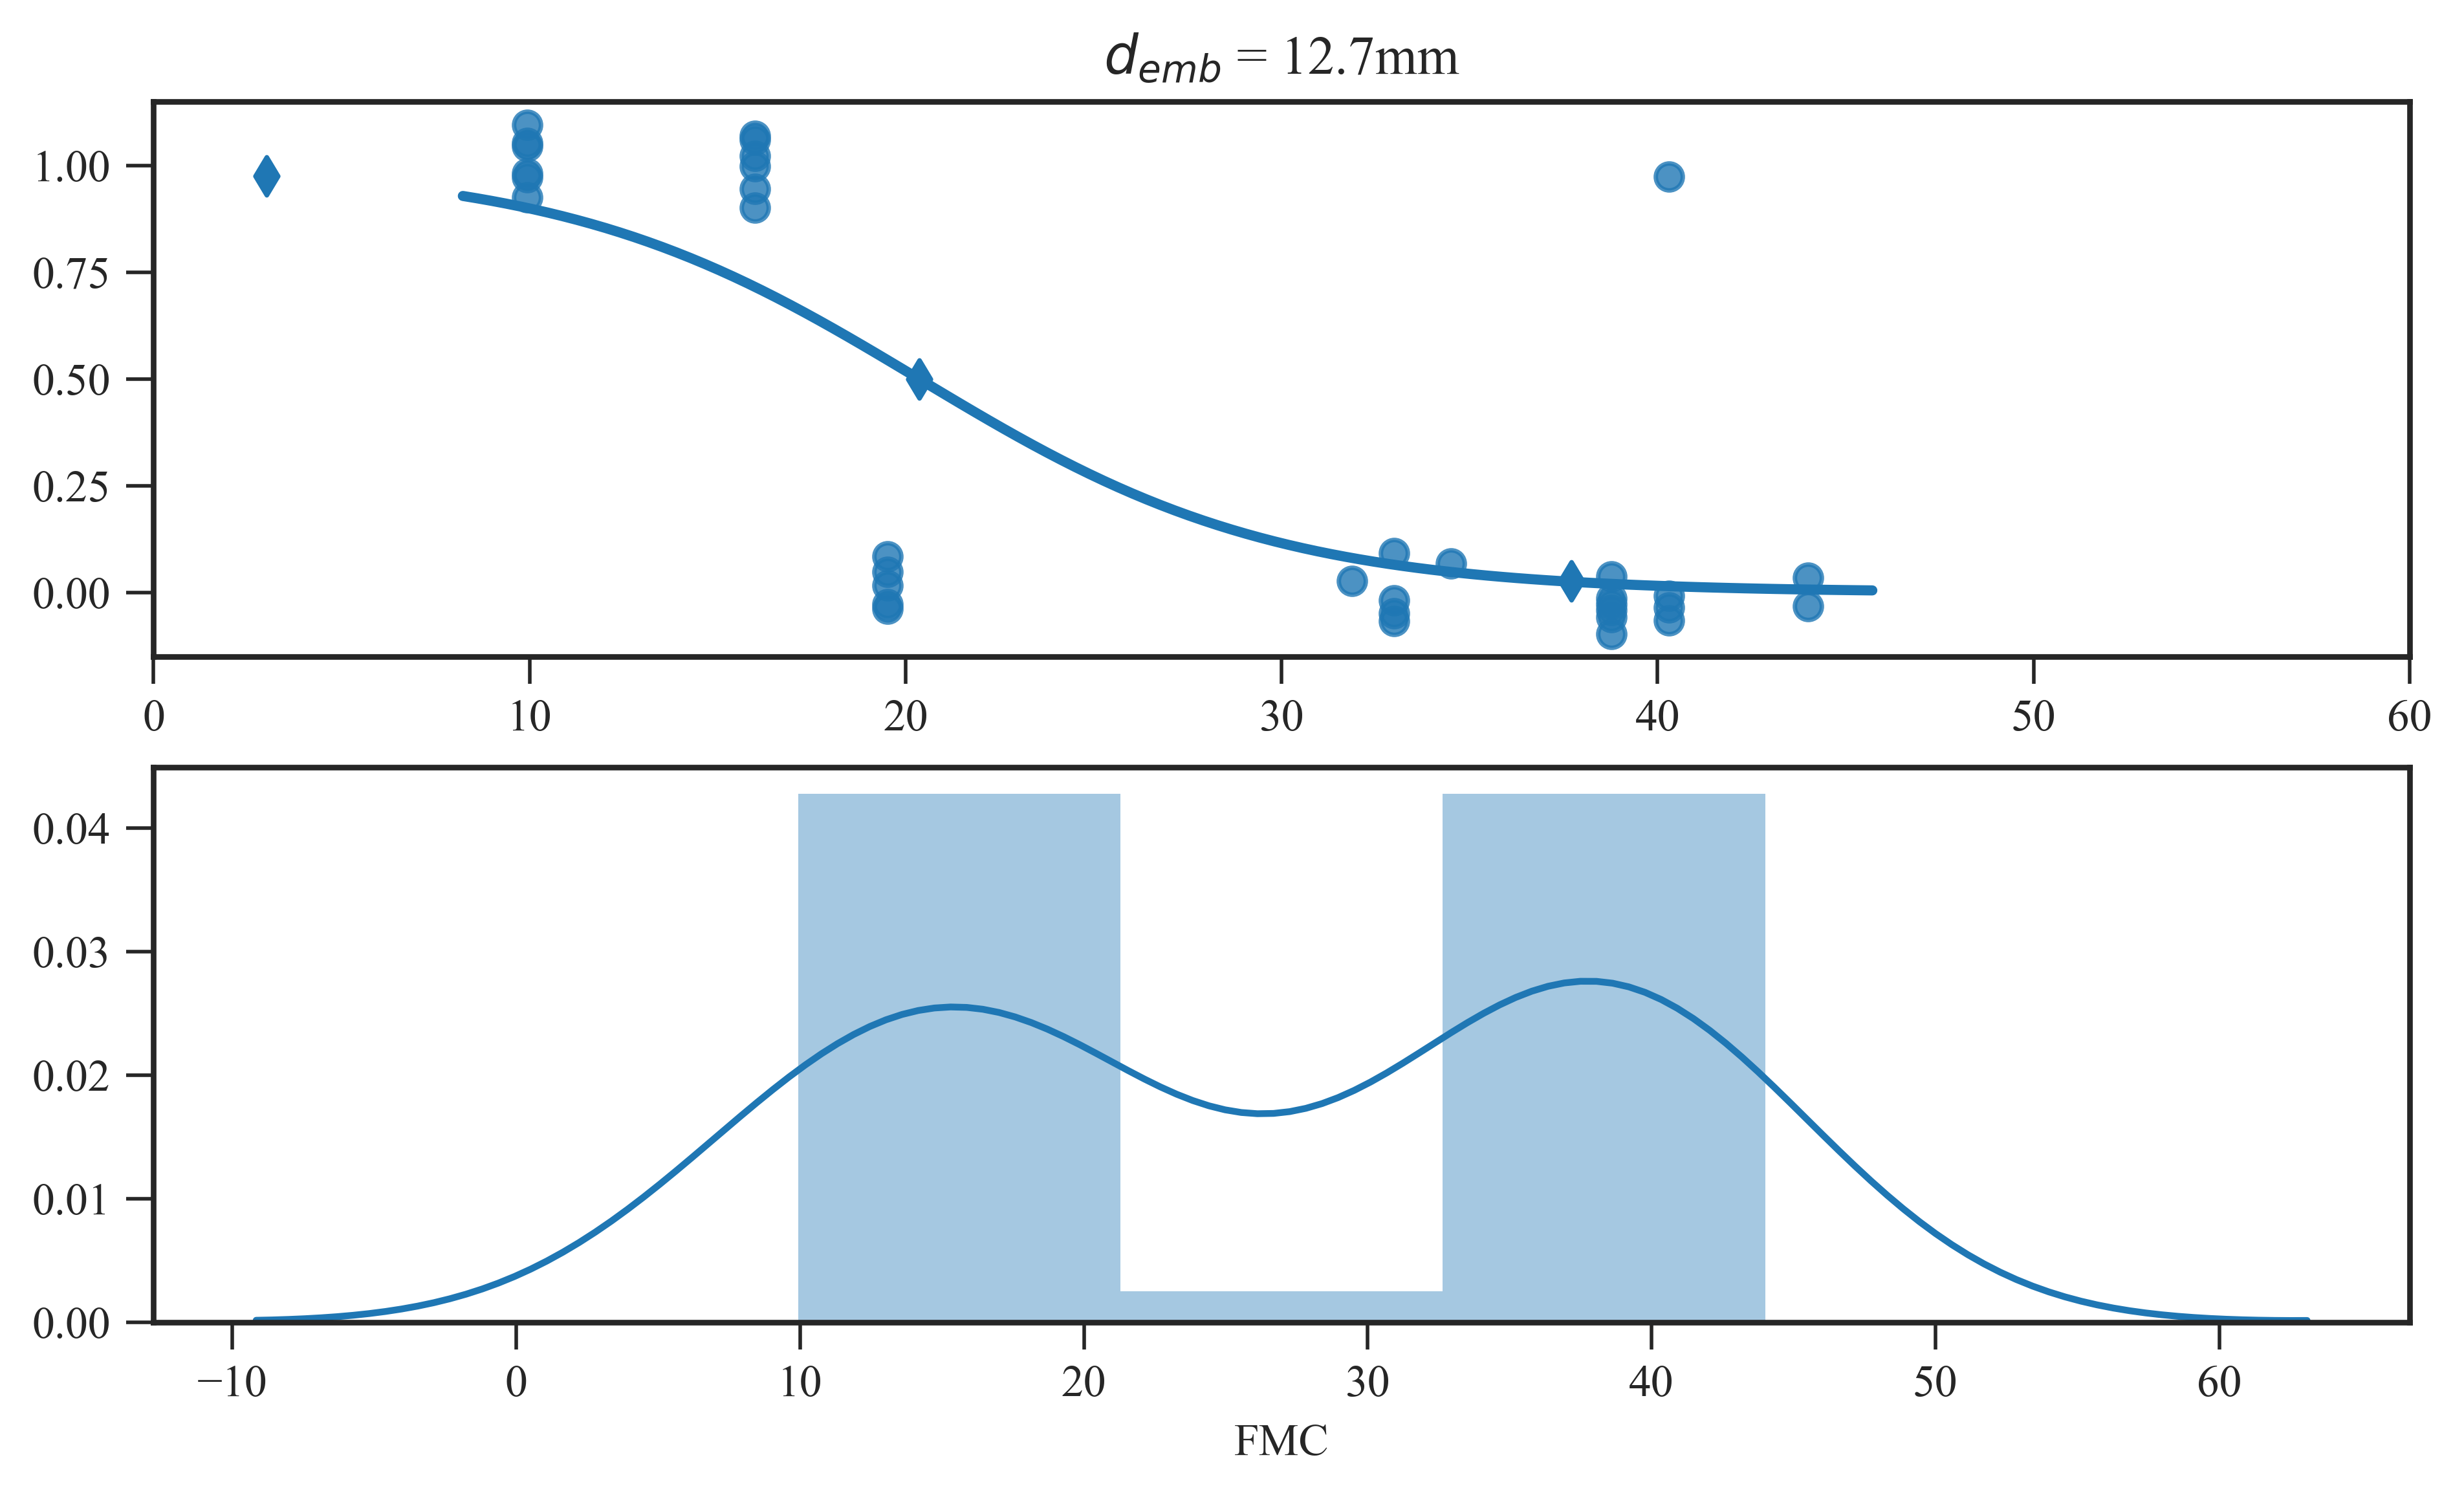

In [87]:
fig, ax = plt.subplots(ncols = 1, nrows=2, sharey='row', sharex=False)
MC_bnd = np.zeros((len(emb_diams),3))
error_lvls = np.array([.5,.0275,.975])
fig.set_size_inches((9,5))
for i, d_emb in enumerate([12.7]):
    BOOL = (RD.Diam == d_emb)&(RD.WS == 0.5)
    sns.distplot(RD[BOOL].FMC,ax = ax[1],color = 'C'+str(i))
    sns.regplot(x=RD[BOOL]["FMC"].values, 
                y=RD[BOOL]["ResBin"].values,
                y_jitter=.1, logistic=True, ax = ax[0], color='C'+str(i), n_boot=200)
    log_fit = log_reg(RD[BOOL]["FMC"].values,
                      RD[BOOL]["ResBin"].values)
    MC_bnd[i] =  log_fit.get_errorbar()[:,0,0]
    ax[0].scatter(log_fit.get_errorbar(), error_lvls,color = 'C'+str(i),marker='d')
    ax[0].set_title("$d_{emb}$"+" = {0}mm".format(d_emb))
    ax[0].set_ylim((-.15,1.15));       ax[0].set_xlim((0,60))
plt.show()

In [72]:
# MC_bnd[3]


d_2 = np.array([1.6,3.18])
MC_2 =  np.array([0,.05,])

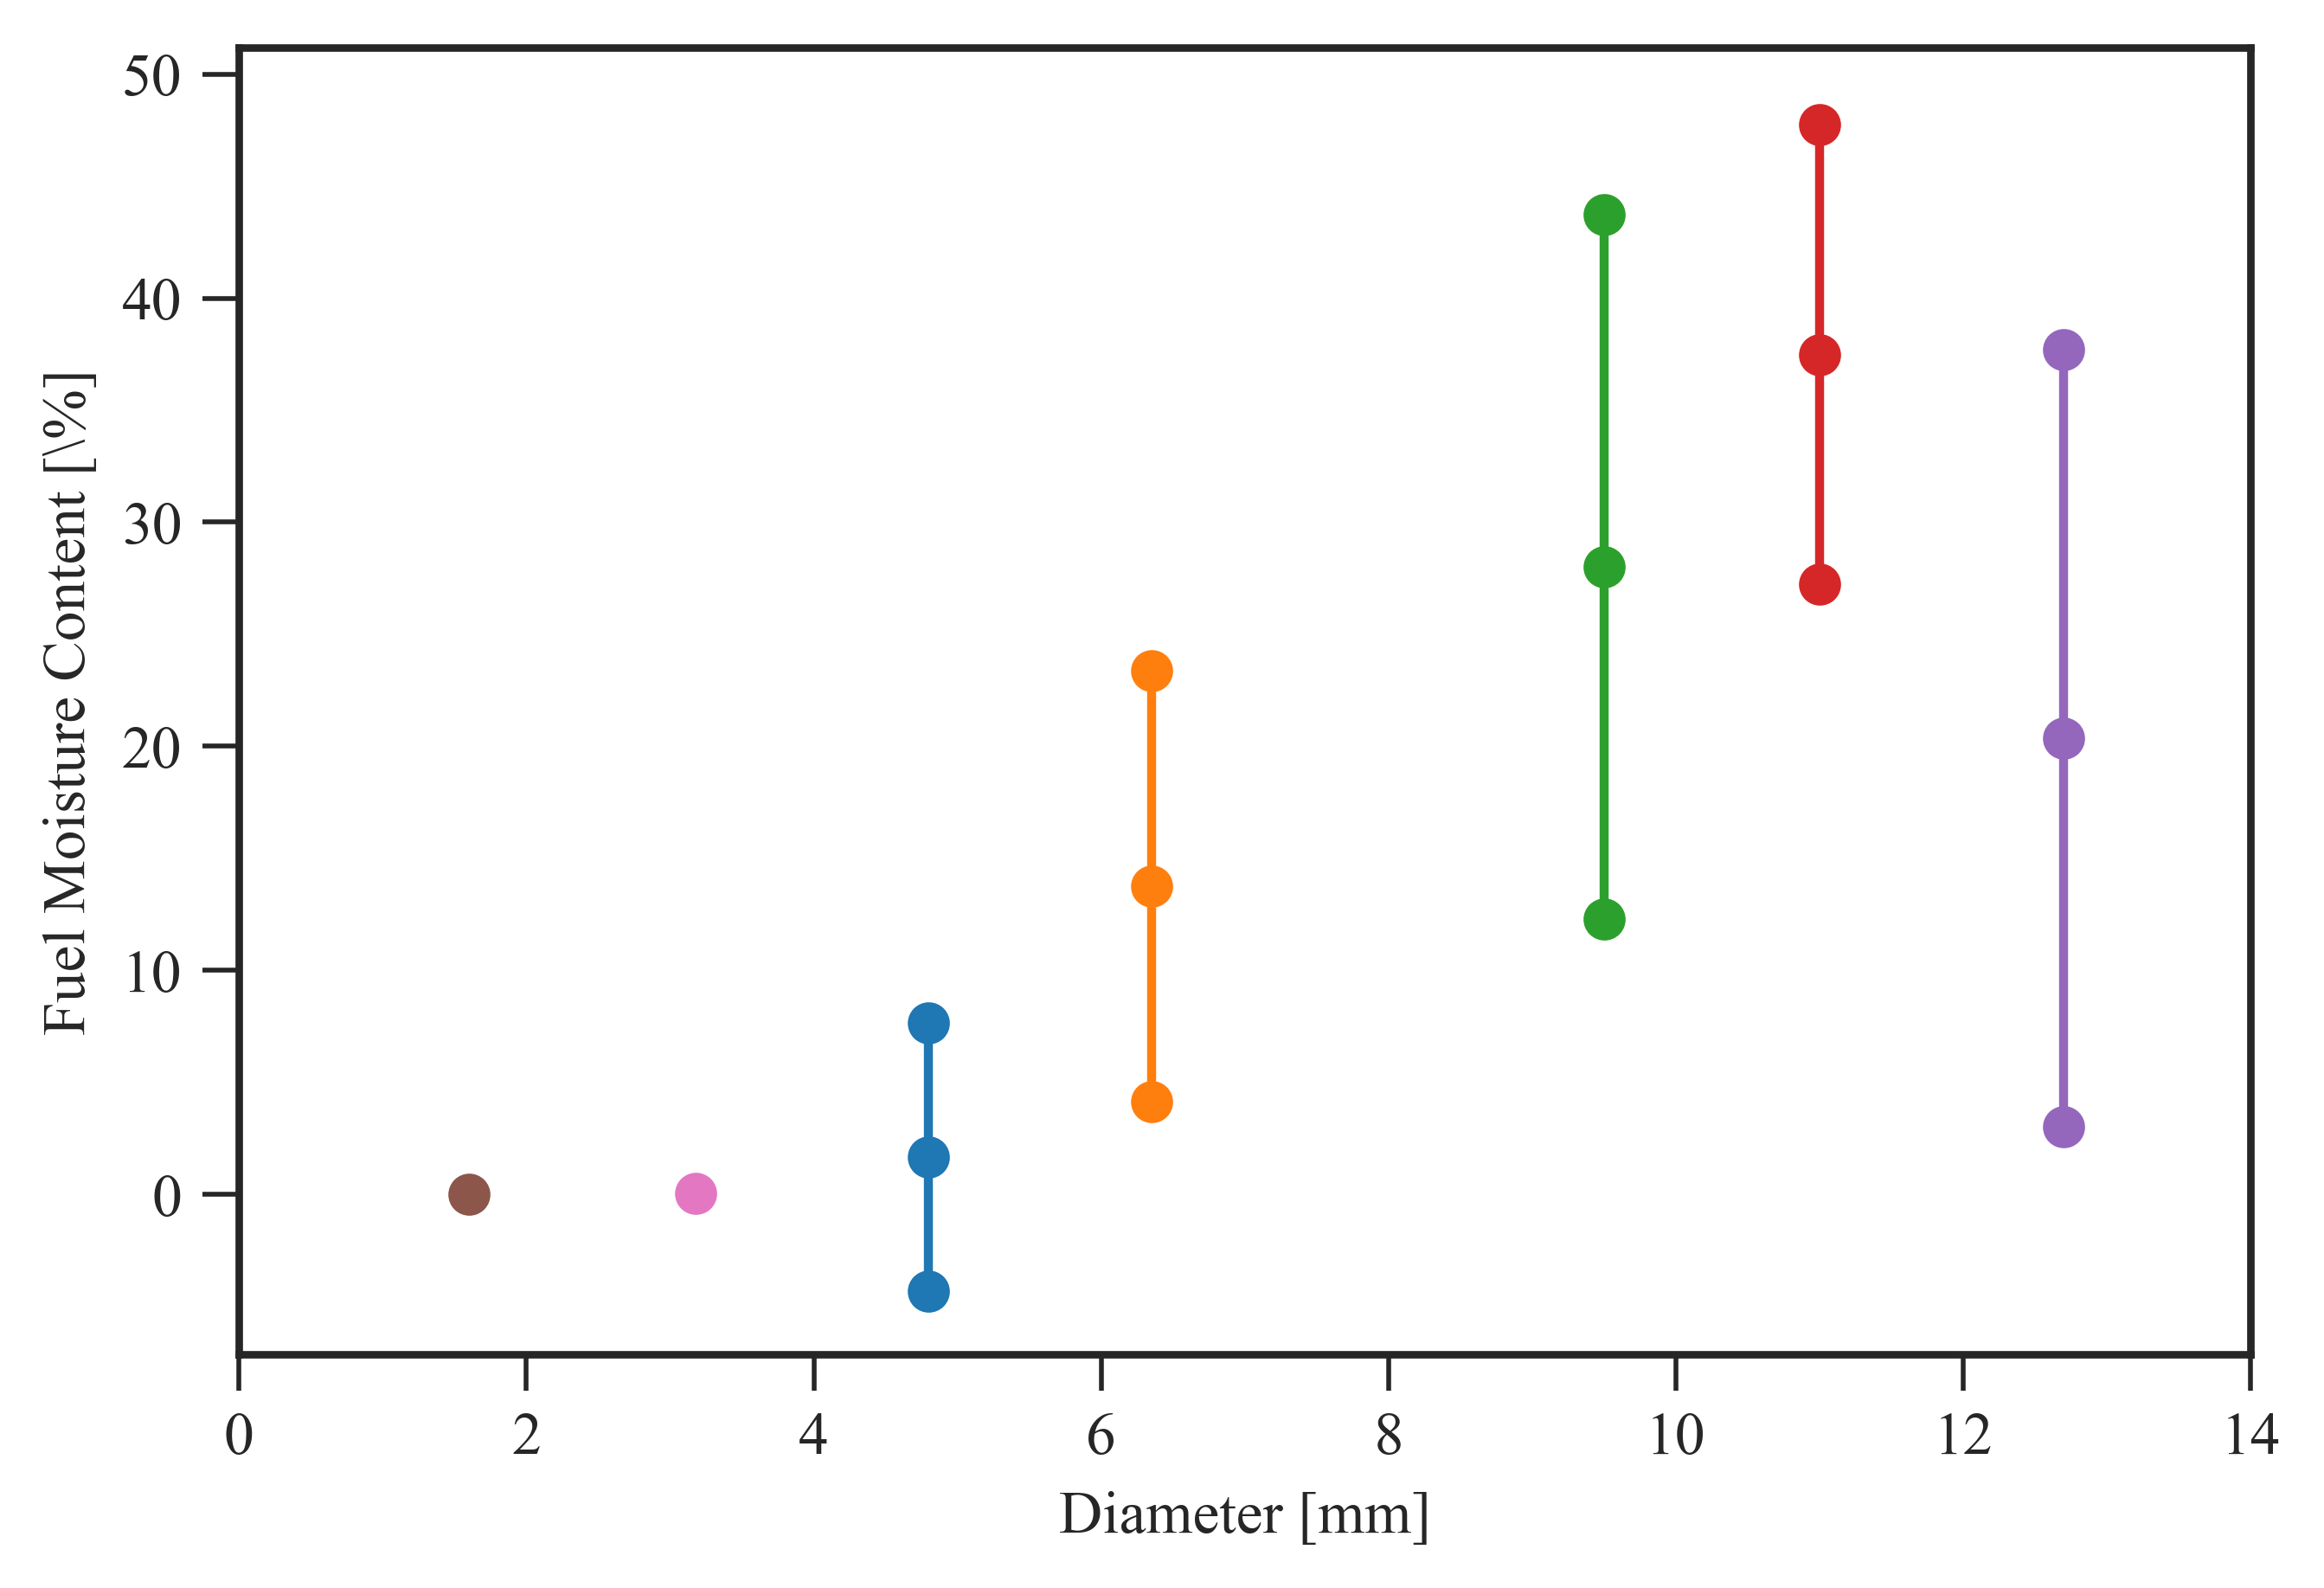

In [76]:
fig, ax = plt.subplots()

for i, d_emb in enumerate(emb_diams):
    ax.errorbar(d_emb,MC_bnd[i,0],yerr=abs(MC_bnd[i,1]-MC_bnd[i,0]),
#                 uplims =MC_bnd[i,1], lolims=MC_bnd[i,2],
                color ='C'+str(i))
    ax.scatter(d_emb*np.ones(3),MC_bnd[i,:],
               color ='C'+str(i))
    
    
for i, d_emb in enumerate(d_2):
    ax.scatter(d_emb,MC_2[i],
               color ='C'+str(i+len(emb_diams)))
    
ax.set_xlim((0,14))
ax.set_xlabel("Diameter [mm]")
ax.set_ylabel("Fuel Moisture Content [\%]")
plt.show()

In [ ]:
for i in 

In [56]:
ssslog_fit.get_errorbar()

array([ 1.65901826,  7.63807228, -4.32003577])

ValueError: zero-size array to reduction operation maximum which has no identity

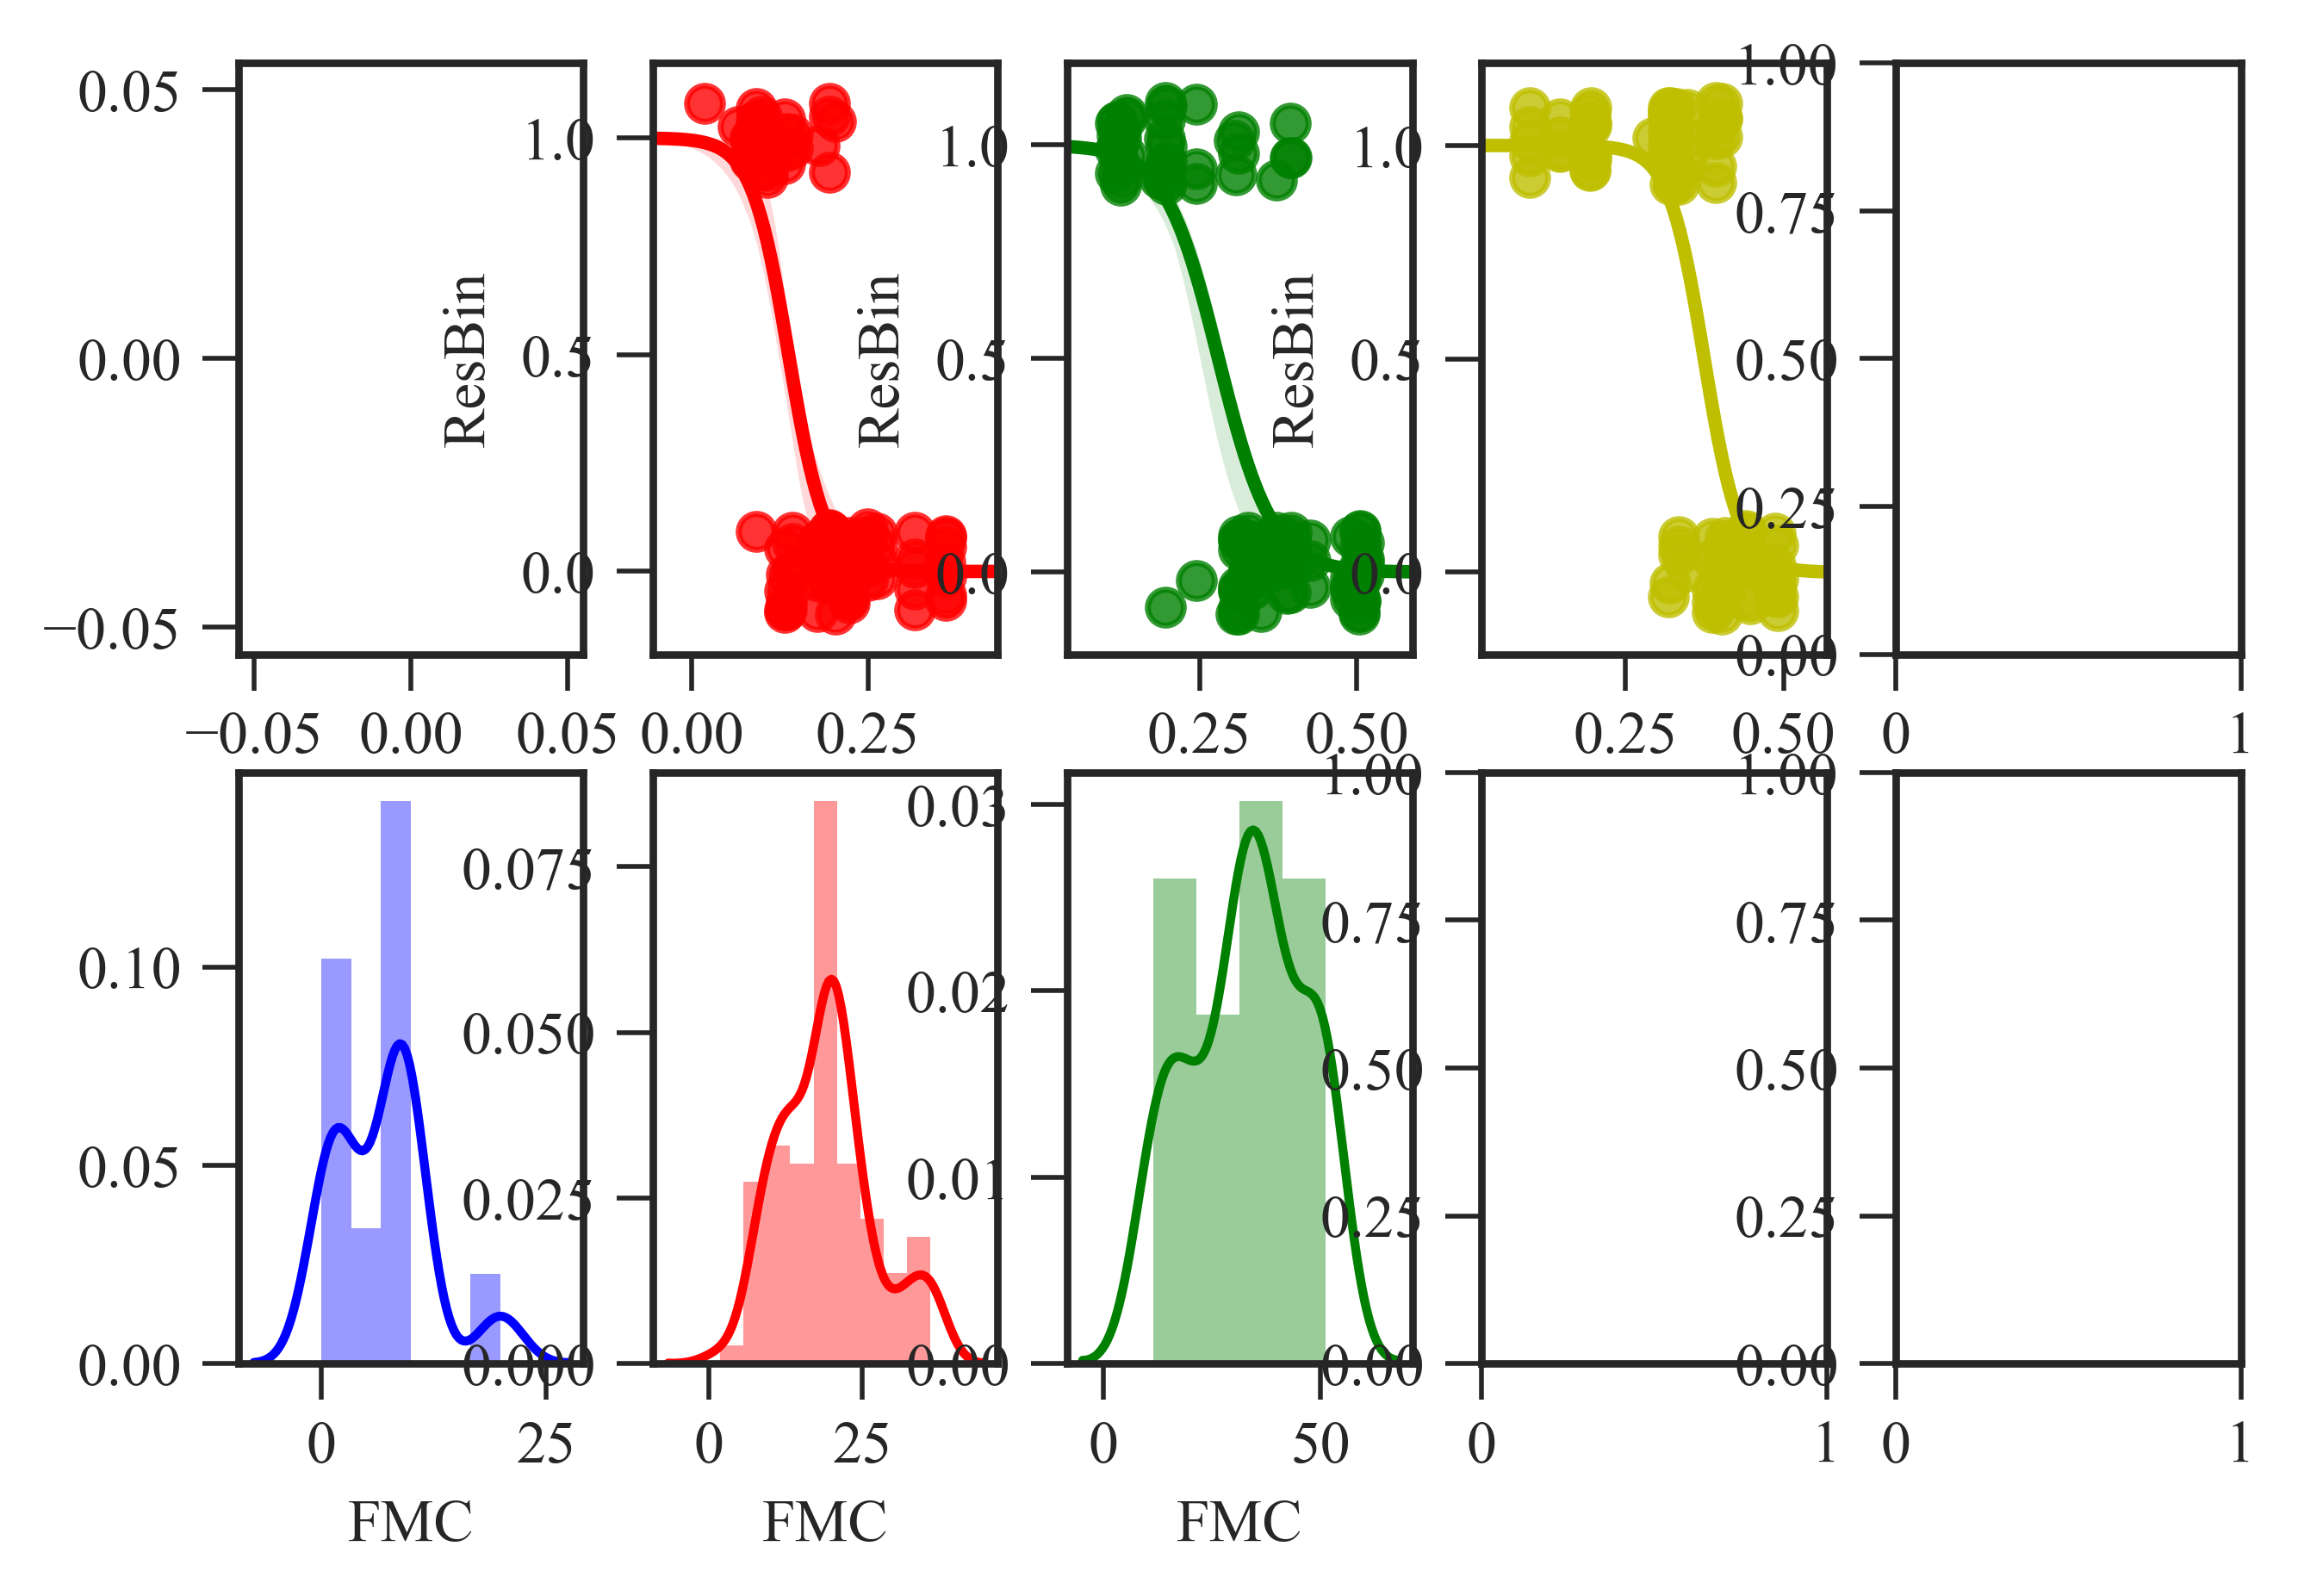

In [13]:
fig, ax = plt.subplots(ncols = 5, nrows=2)
# sns.distplot(RD[(RD.Diam == 3.18)&(RD.WS == 0.5)].MC,ax = ax[1,0],color = 'b')
# sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == 3.18)&(RD.WS == 0.5)], y_jitter=.1,logistic=True,ax = ax[0,3],color='y',n_boot=0)
sns.distplot(RD[(RD.Diam == 4.8)&(RD.WS == 0.5)].FMC,ax = ax[1,0],color = 'b')
sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == 11.)&(RD.WS == 0.5)], y_jitter=.1,logistic=True,ax = ax[0,3],color='y',n_boot=0)

sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == 6.35)&(RD.WS == 0.5)], y_jitter=.1,logistic=True,ax = ax[0,1],color='r',n_boot=10)
sns.distplot(RD[(RD.Diam == 6.35)&(RD.WS == 0.5)].FMC,ax = ax[1,1],color='r')
sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == 9.5)&(RD.WS == 0.5)], y_jitter=.1,logistic=True,ax = ax[0,2],color='g',n_boot=10)
sns.distplot(RD[(RD.Diam == 9.5)&(RD.WS == 0.5)].FMC,ax = ax[1,2],color='g')
sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == 11.1)&(RD.WS == 0.5)], y_jitter=.1,logistic=True,ax = ax[0,0],color='b',n_boot=10)
sns.distplot(RD[(RD.Diam == 11.)&(RD.WS == 0.5)].FMC,ax = ax[1,3],color = 'y')
sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == 12.7)&(RD.WS == 0.5)], y_jitter=.1,logistic=True,ax = ax[0,5],color='b',n_boot=10)
sns.distplot(RD[(RD.Diam == 11.)&(RD.WS == 0.5)].FMC,ax = ax[1,3],color = 'y')
# sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == 12.7)&(RD.WS == 0.5)], y_jitter=.1,logistic=True,ax = ax[0,4],color='m',n_boot=0)

# ax[0,4].scatter(x="MC", y="ResBin", data=RD[(RD.Diam == 12.7)&(RD.WS == 0.5)],color='m')
# sns.distplot(RD[(RD.Diam == 12.7)&(RD.WS == 0.5)].MC,ax = ax[1,4],color = 'm')
# MC_arr = np.array([0,1.5,13.3,31.5,38])
MC_arr = np.array([1.5,13.3,31.5,38,-11])
[ax[0,i].scatter(MC_arr[i]*1e-2,np.ones_like(MC_arr[i])*.5,c='b',s= MS,zorder=999) for i in np.arange(5)]

# ax[0,0].scatter(MC_arr[1::]*1e-2,np.ones_like(MC_arr[1::])*.5,c='b',s= MS,zorder=999)
[[ax[i,j].set_xlim((0,.55))for i in np.arange(2)] for j in np.arange(5)]
# [ax[0,i].set_ylabel("Ignition Propensity",fontsize = 0.0) for i in np.arange(5)]
[ax[0,i].set_ylim((-.2,1.2)) for i in np.arange(5)]
[ax[1,i].set_ylim((0,25)) for i in np.arange(5)]
ax[0,0].set_title("4.8mm Diameter Embers")
ax[0,1].set_title("6.35mm Diameter Embers")
ax[0,2].set_title("9.53mm Diameter Embers")
ax[0,3].set_title("11.1mm Diameter Embers")
# ax[0,4].set_title("12.7mm Diameter Embers")
# ax[0,1].get_ylabel().set_fontsize(0.0)
fig.set_size_inches((14,6));   fig.tight_layout();   plt.show()
fig.savefig("testing.png")

In [20]:
RD['MC'].max()

0.51154132539091579

C:\Users\urban\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


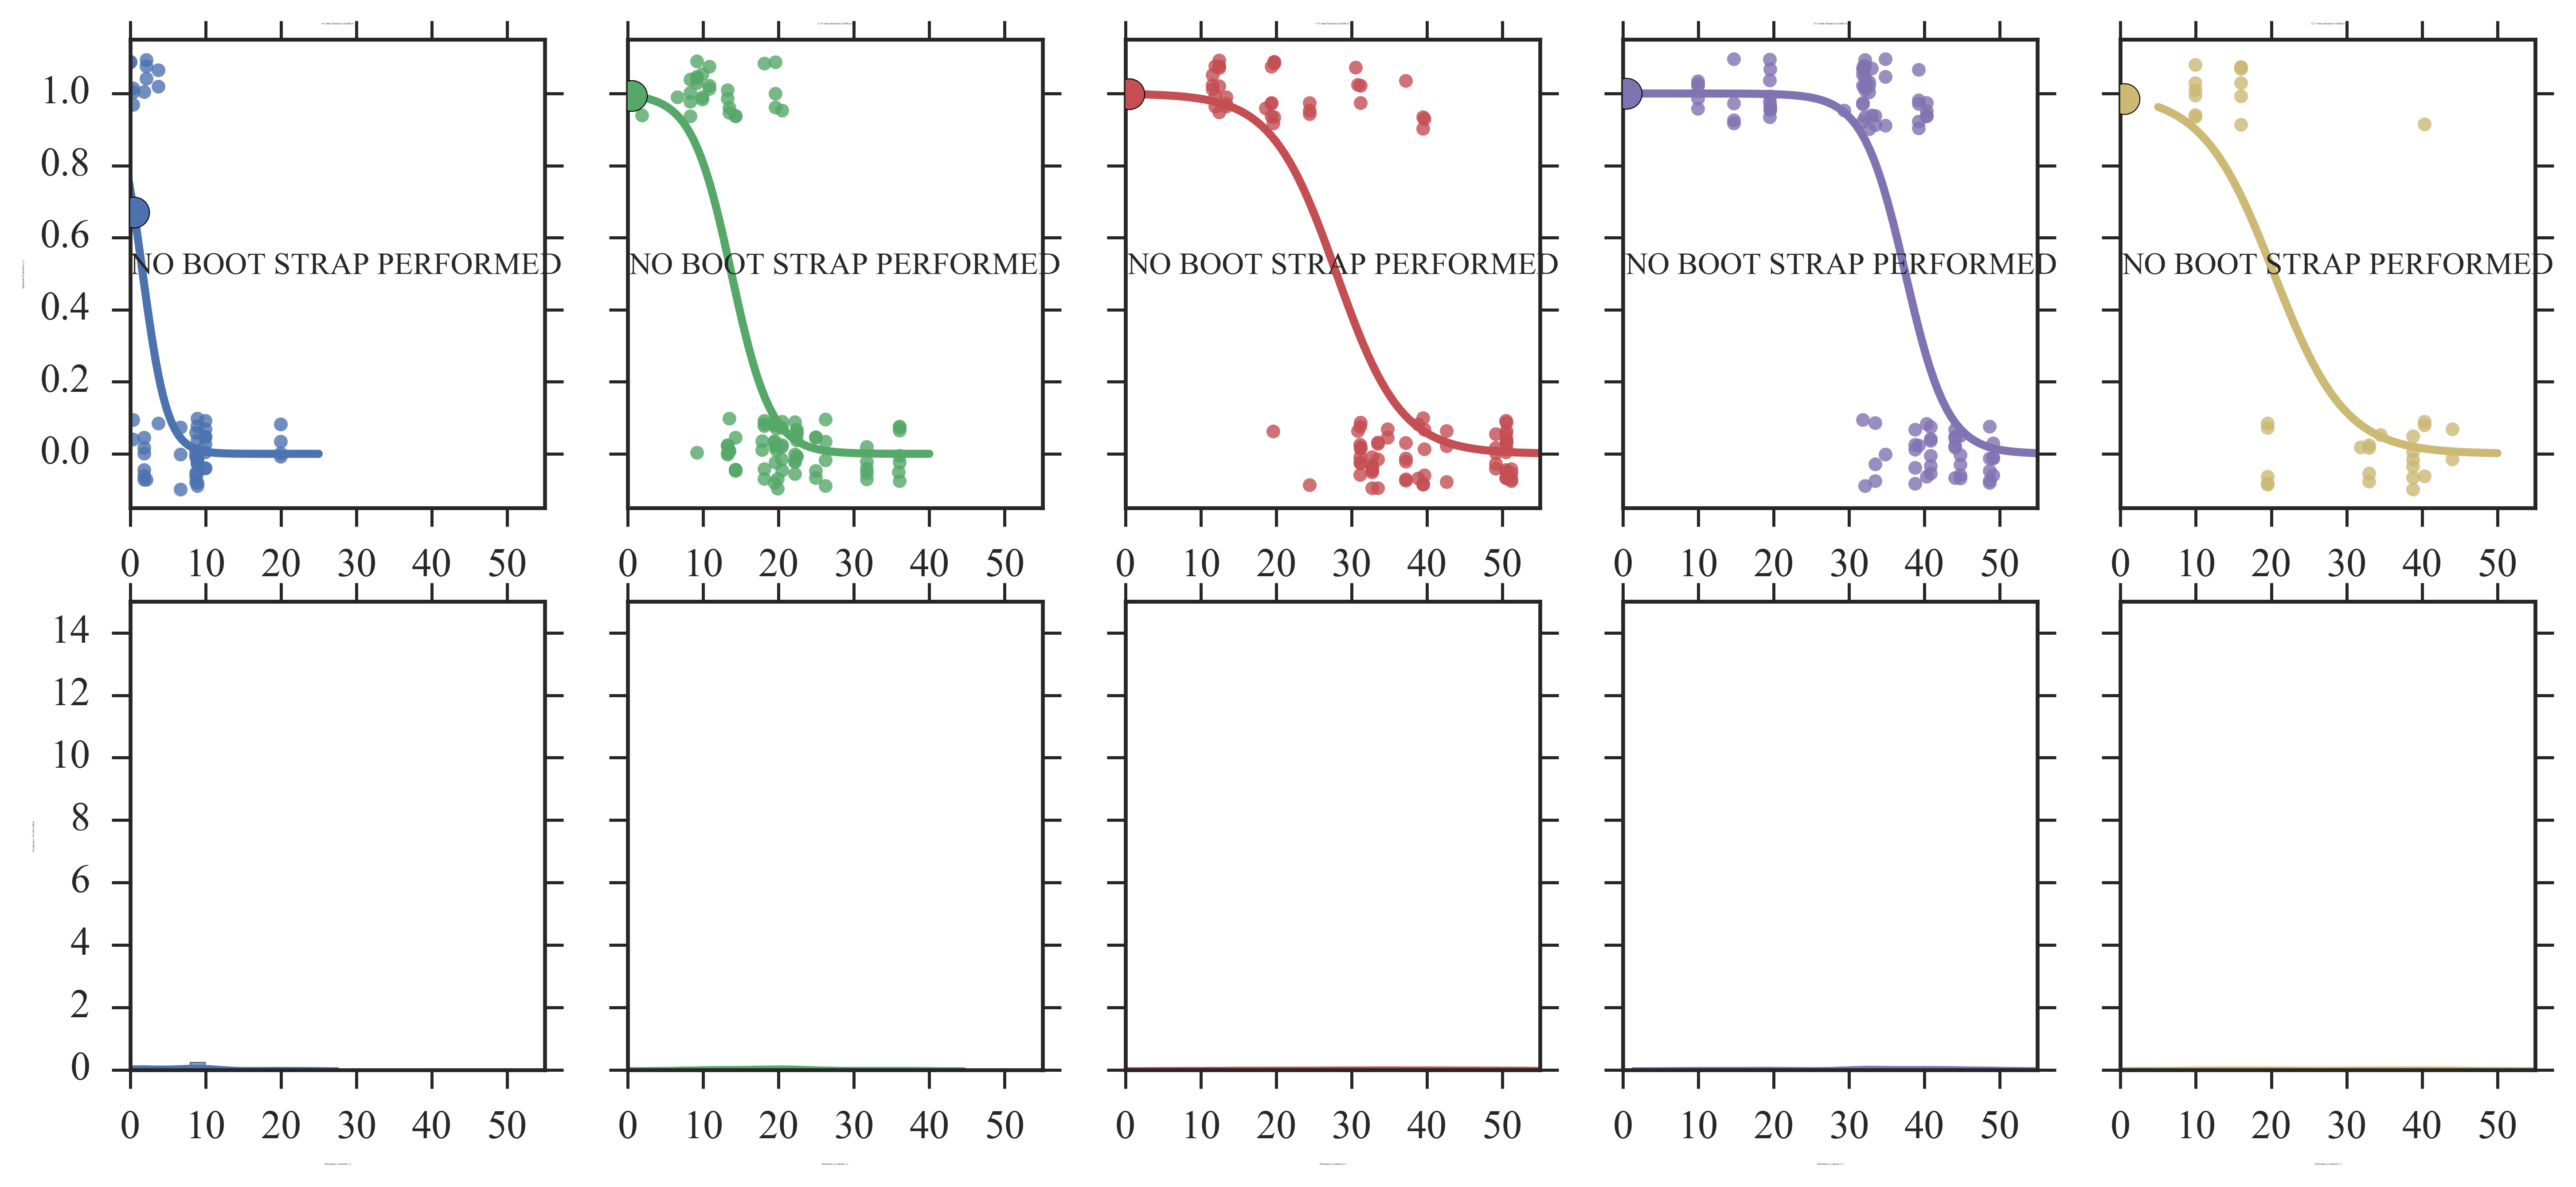

In [23]:
Dp_l = [4.8,6.35,9.5,11.,12.7];Ncols = len(Dp_l);
# MC_arr = np.array([1.5,13.3,28.5,38,-11])
Dp_plt = np.array([4.8,6.35,9.5,11.,12.7])
MC_arr = np.linspace(0,.5,10000)
Error_plt = np.ones(Dp_plt.shape)
MC_plt = np.ones(Dp_plt.shape)
FS = 1.
MS = 100
fig, ax = plt.subplots(ncols = Ncols, nrows=2,sharey='row')
for l in range(Ncols):
    yy = get_log(RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].MC.values,
                 RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].ResBin.values,
                 MC_arr)
    MC_plt[l] = MC_arr[np.absolute(yy-.5).min() == np.absolute(yy-.5)]
 
    try: 
        N_BOOTS = 100
        sns.distplot(RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].FMC,
                     ax = ax[1,l],color = Colors[l],bins = 10)

        sns.regplot(x="FMC"*100, y="ResBin", data=RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)],
                    y_jitter=.1, logistic=True, ax = ax[0,l], color=Colors[l], n_boot=N_BOOTS)
    except: 
        N_BOOTS = 0
        sns.distplot(RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].FMC,ax = ax[1,l],color = Colors[l],bins = 10)
        sns.regplot(x="FMC", y="ResBin", data=RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)],
                    y_jitter=.1, logistic=True, ax = ax[0,l], color=Colors[l], n_boot=N_BOOTS)
        ax[0,l].text(MC_arr[np.absolute(yy-.5).min() == np.absolute(yy-.5)],
                     .5,
                     "NO BOOT STRAP PERFORMED")
    ax[0,l].set_title(str(Dp_l[l])+" mm Diameter Embers",fontsize=FS)
#     logit = sm.Logit(RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].ResBin,
#                      RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].MC
# #                      missing='drop'
#                      )
    yy = get_log(RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].FMC.values,
                 RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].ResBin.values,
                 MC_arr)
    MC_plt[l] = MC_arr[np.absolute(yy-.5).min() == np.absolute(yy-.5)]
    Error_plt[l] = MC_arr[np.absolute(yy-.05).min() == np.absolute(yy-.05)]-MC_arr[np.absolute(yy-.5).min() == np.absolute(yy-.5)]

    ax[0,l].scatter(MC_arr[np.absolute(yy-.5).min() == np.absolute(yy-.5)],
                    yy[np.absolute(yy-.5).min() == np.absolute(yy-.5)],
                    c=Colors[l],s= MS,zorder=999) 
#     ax[0,l].scatter(MC_arr[np.absolute(yy-.05).min() == np.absolute(yy-.05)],
#                     yy[np.absolute(yy-.05).min() == np.absolute(yy-.05)],
#                     c='b',s= MS,zorder=999) 

    [ax[i,l].set_xlim((0,55)) for i in np.arange(2)]
    ax[1,l].set_xlabel("Moisture Content [-]",fontsize = FS)
    ax[0,l].set_xlabel("",fontsize = 0)
    [ax[i,l].set_ylabel("",fontsize = 0) for i in np.arange(2)]
    [ax[i,l].tick_params(axis='both', which='major', labelsize=13) for i in np.arange(2)]

ax[0,0].set_ylabel("Ignition Propensity [-]",fontsize = FS)
ax[1,0].set_ylabel("Frequency of tests taken",fontsize=FS)
    
[ax[0,i].set_ylim((-.15,1.15)) for i in np.arange(Ncols)]
[ax[1,i].set_ylim((0,15)) for i in np.arange(Ncols)]

fig.set_size_inches((14,6));   #fig.tight_layout();   
plt.show()
fig.savefig("LogisticaANDdist.png",dpi= 400)

In [ ]:
RD[].columns

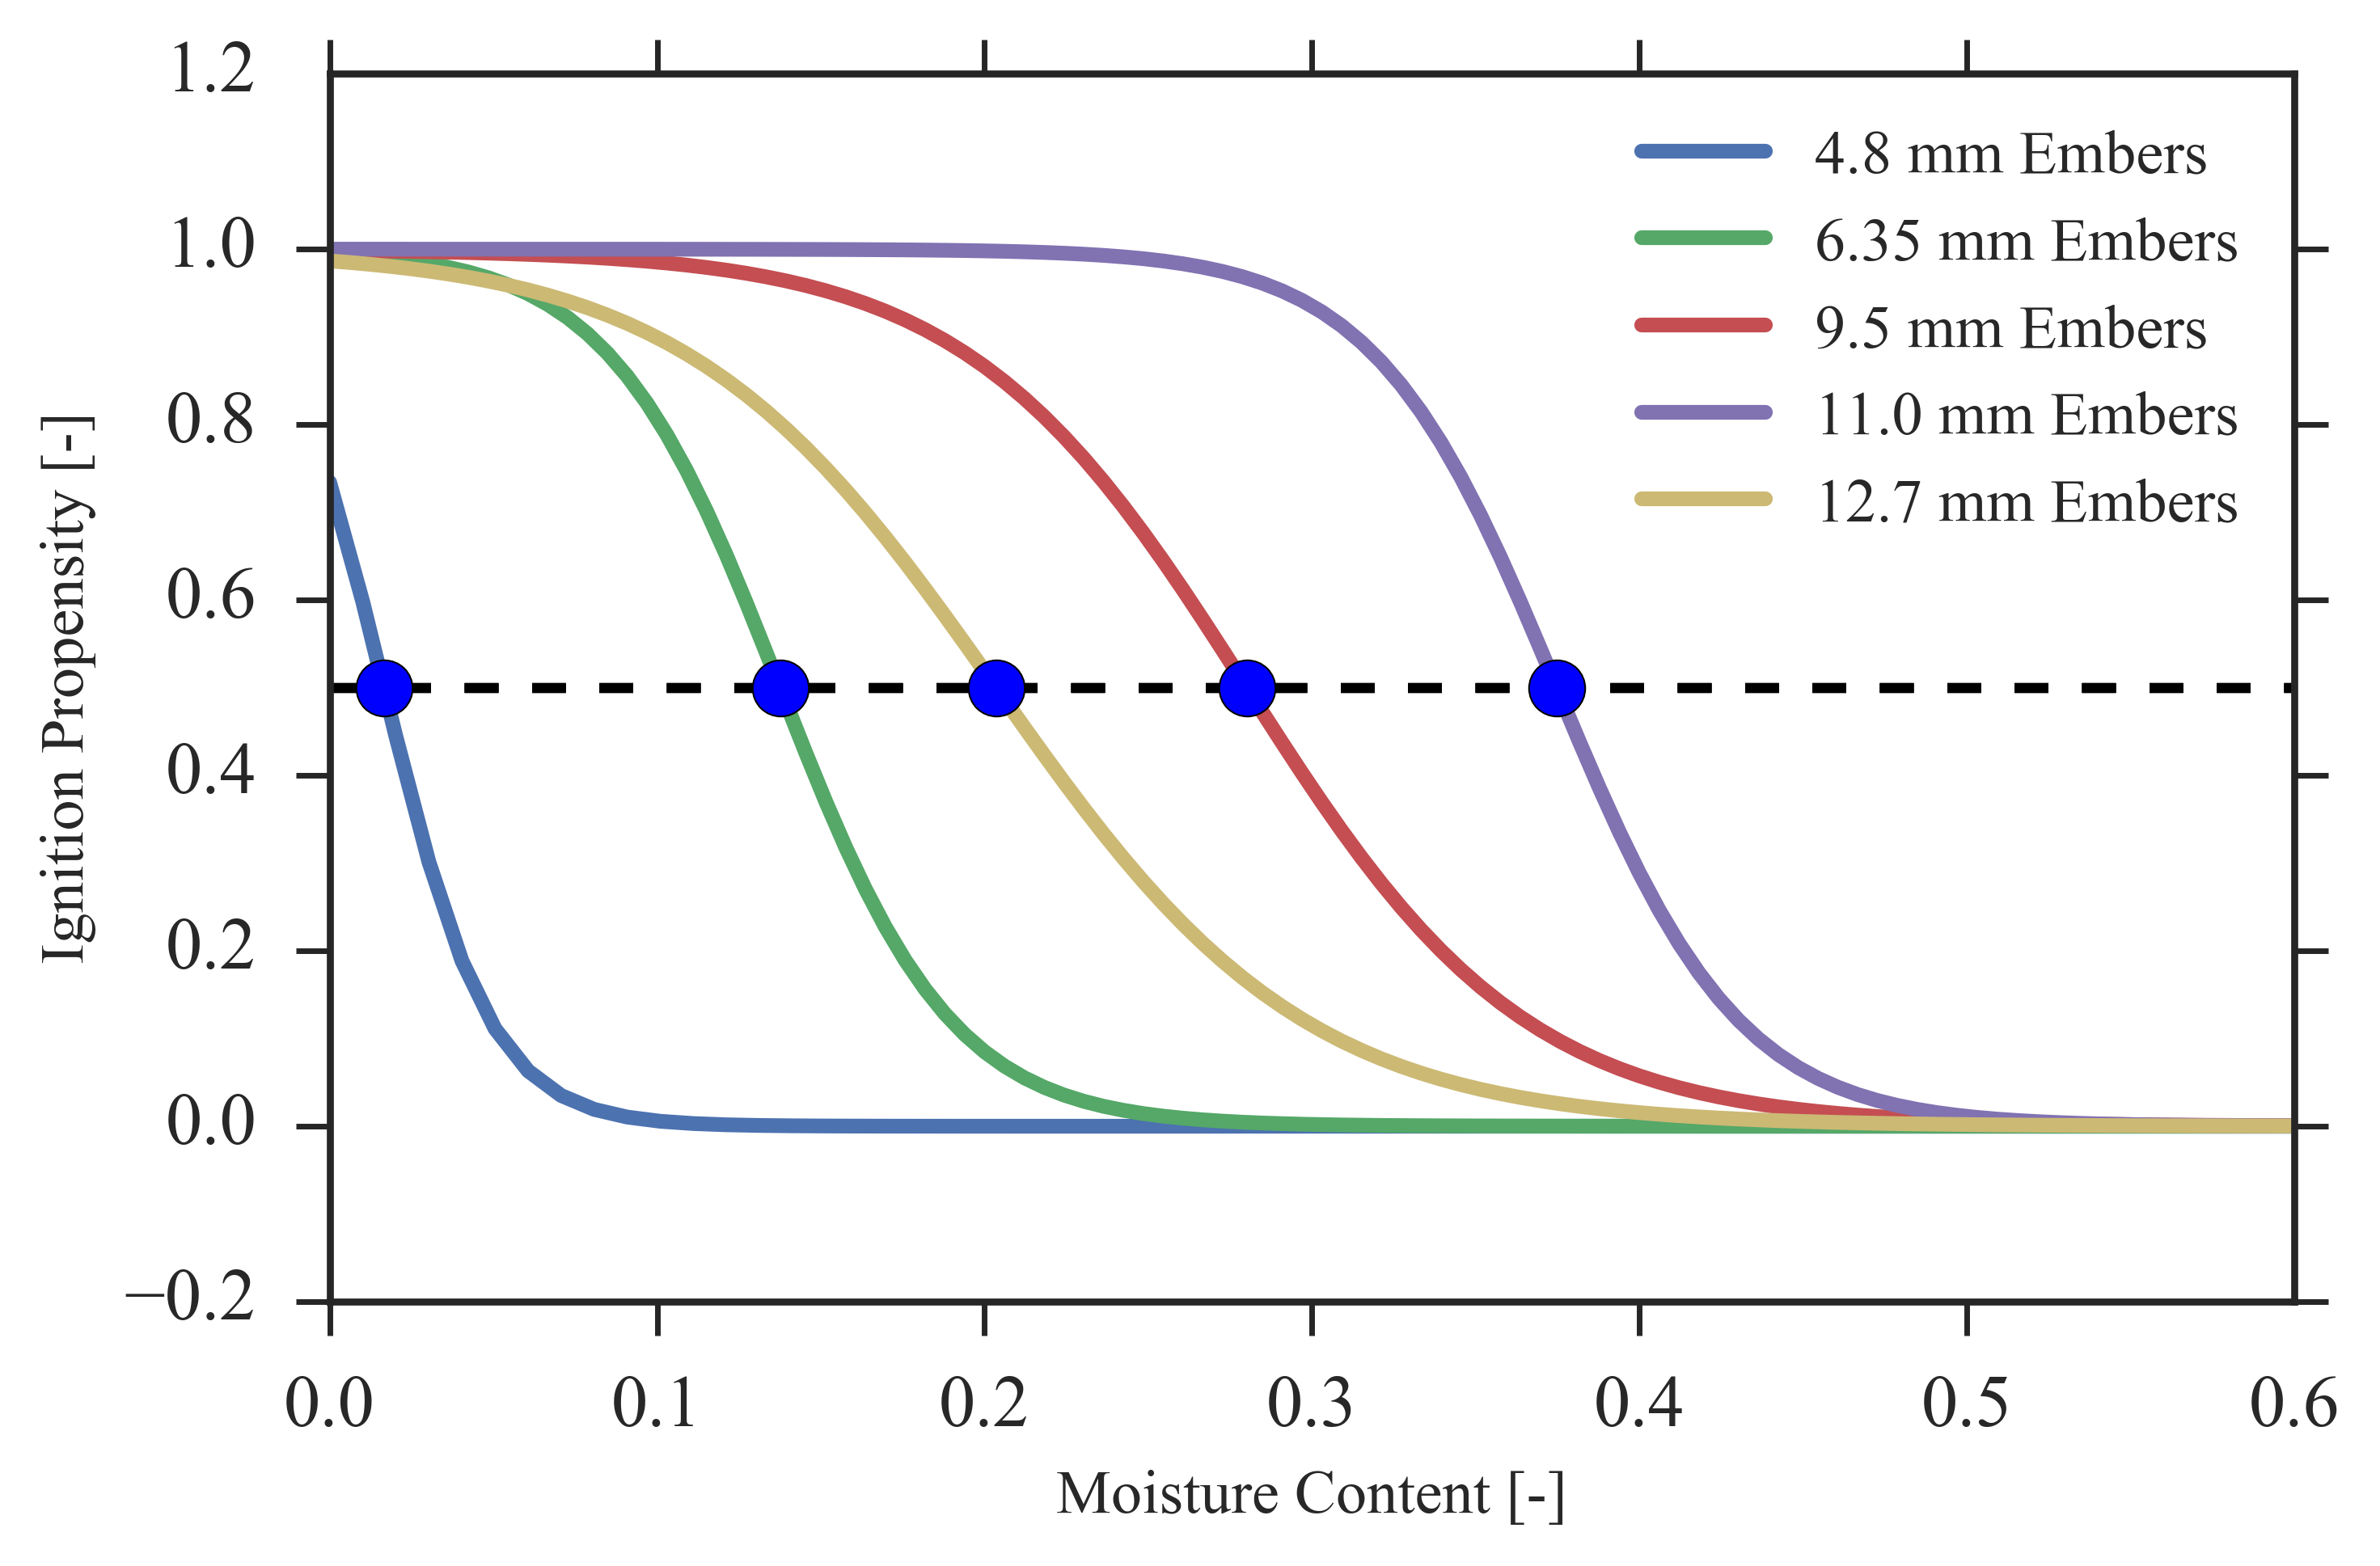

In [10]:
# Dp_l = [4.8,6.35,9.5,11.];
Ncols = len(Dp_l)
fig, ax = plt.subplots(ncols = 1, nrows=1)
for l in range(Ncols):
    sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)], y_jitter=.1,
                logistic=True,color=Colors[l],n_boot=0,scatter=False,label=str(Dp_l[l])+" mm Embers")
#     ax.scatter(MC_arr[l]*1e-2,np.ones_like(MC_arr[l])*.5,c='b',s= MS,zorder=999) 
    yy = get_log(RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].MC.values,
                 RD[(RD.Diam == Dp_l[l])&(RD.WS == 0.5)].ResBin.values,
                 MC_arr)
    ax.scatter(MC_arr[np.absolute(yy-.5).min() == np.absolute(yy-.5)],
               .5,
               c='b',s= MS, zorder=999) 
    ax.plot(np.array([0,1]),.5*np.ones(2),'--k')
    ax.set_xlim((0,.6))
ax.set_xlabel("Moisture Content [-]")
ax.set_ylabel("Ignition Propensity [-]")
ax.set_ylim((-.2,1.2))
plt.legend(fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=13)
fig.set_size_inches((6,4));   fig.tight_layout();   plt.show()
fig.savefig("LogisticsONLY.png",dpi= 400)

In [ ]:
import scipy.constants as cs

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
RD.Diam.unique()

In [ ]:
fig, ax = plt.subplots(ncols=1)
# ax.scatter(RD[(RD.Diam == 3.175)&(RD.WS == 0.5)]["MC"],
#            RD[(RD.Diam == 3.175)&(RD.WS == 0.5)]["ResBin"])
sns.regplot(x="MC", y="ResBin", data=RD[(RD.Diam == 3.175)&(RD.WS == 0.5)], y_jitter=.1,fit_reg =False,
                logistic=False,color=Colors[l],scatter=True,label=str(Dp_l[l])+" mm Embers")


In [ ]:
print(Error_plt2.shape)
print(MC_plt2.shape)
print(Dp_plt2.shape)

C:\Users\urban\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


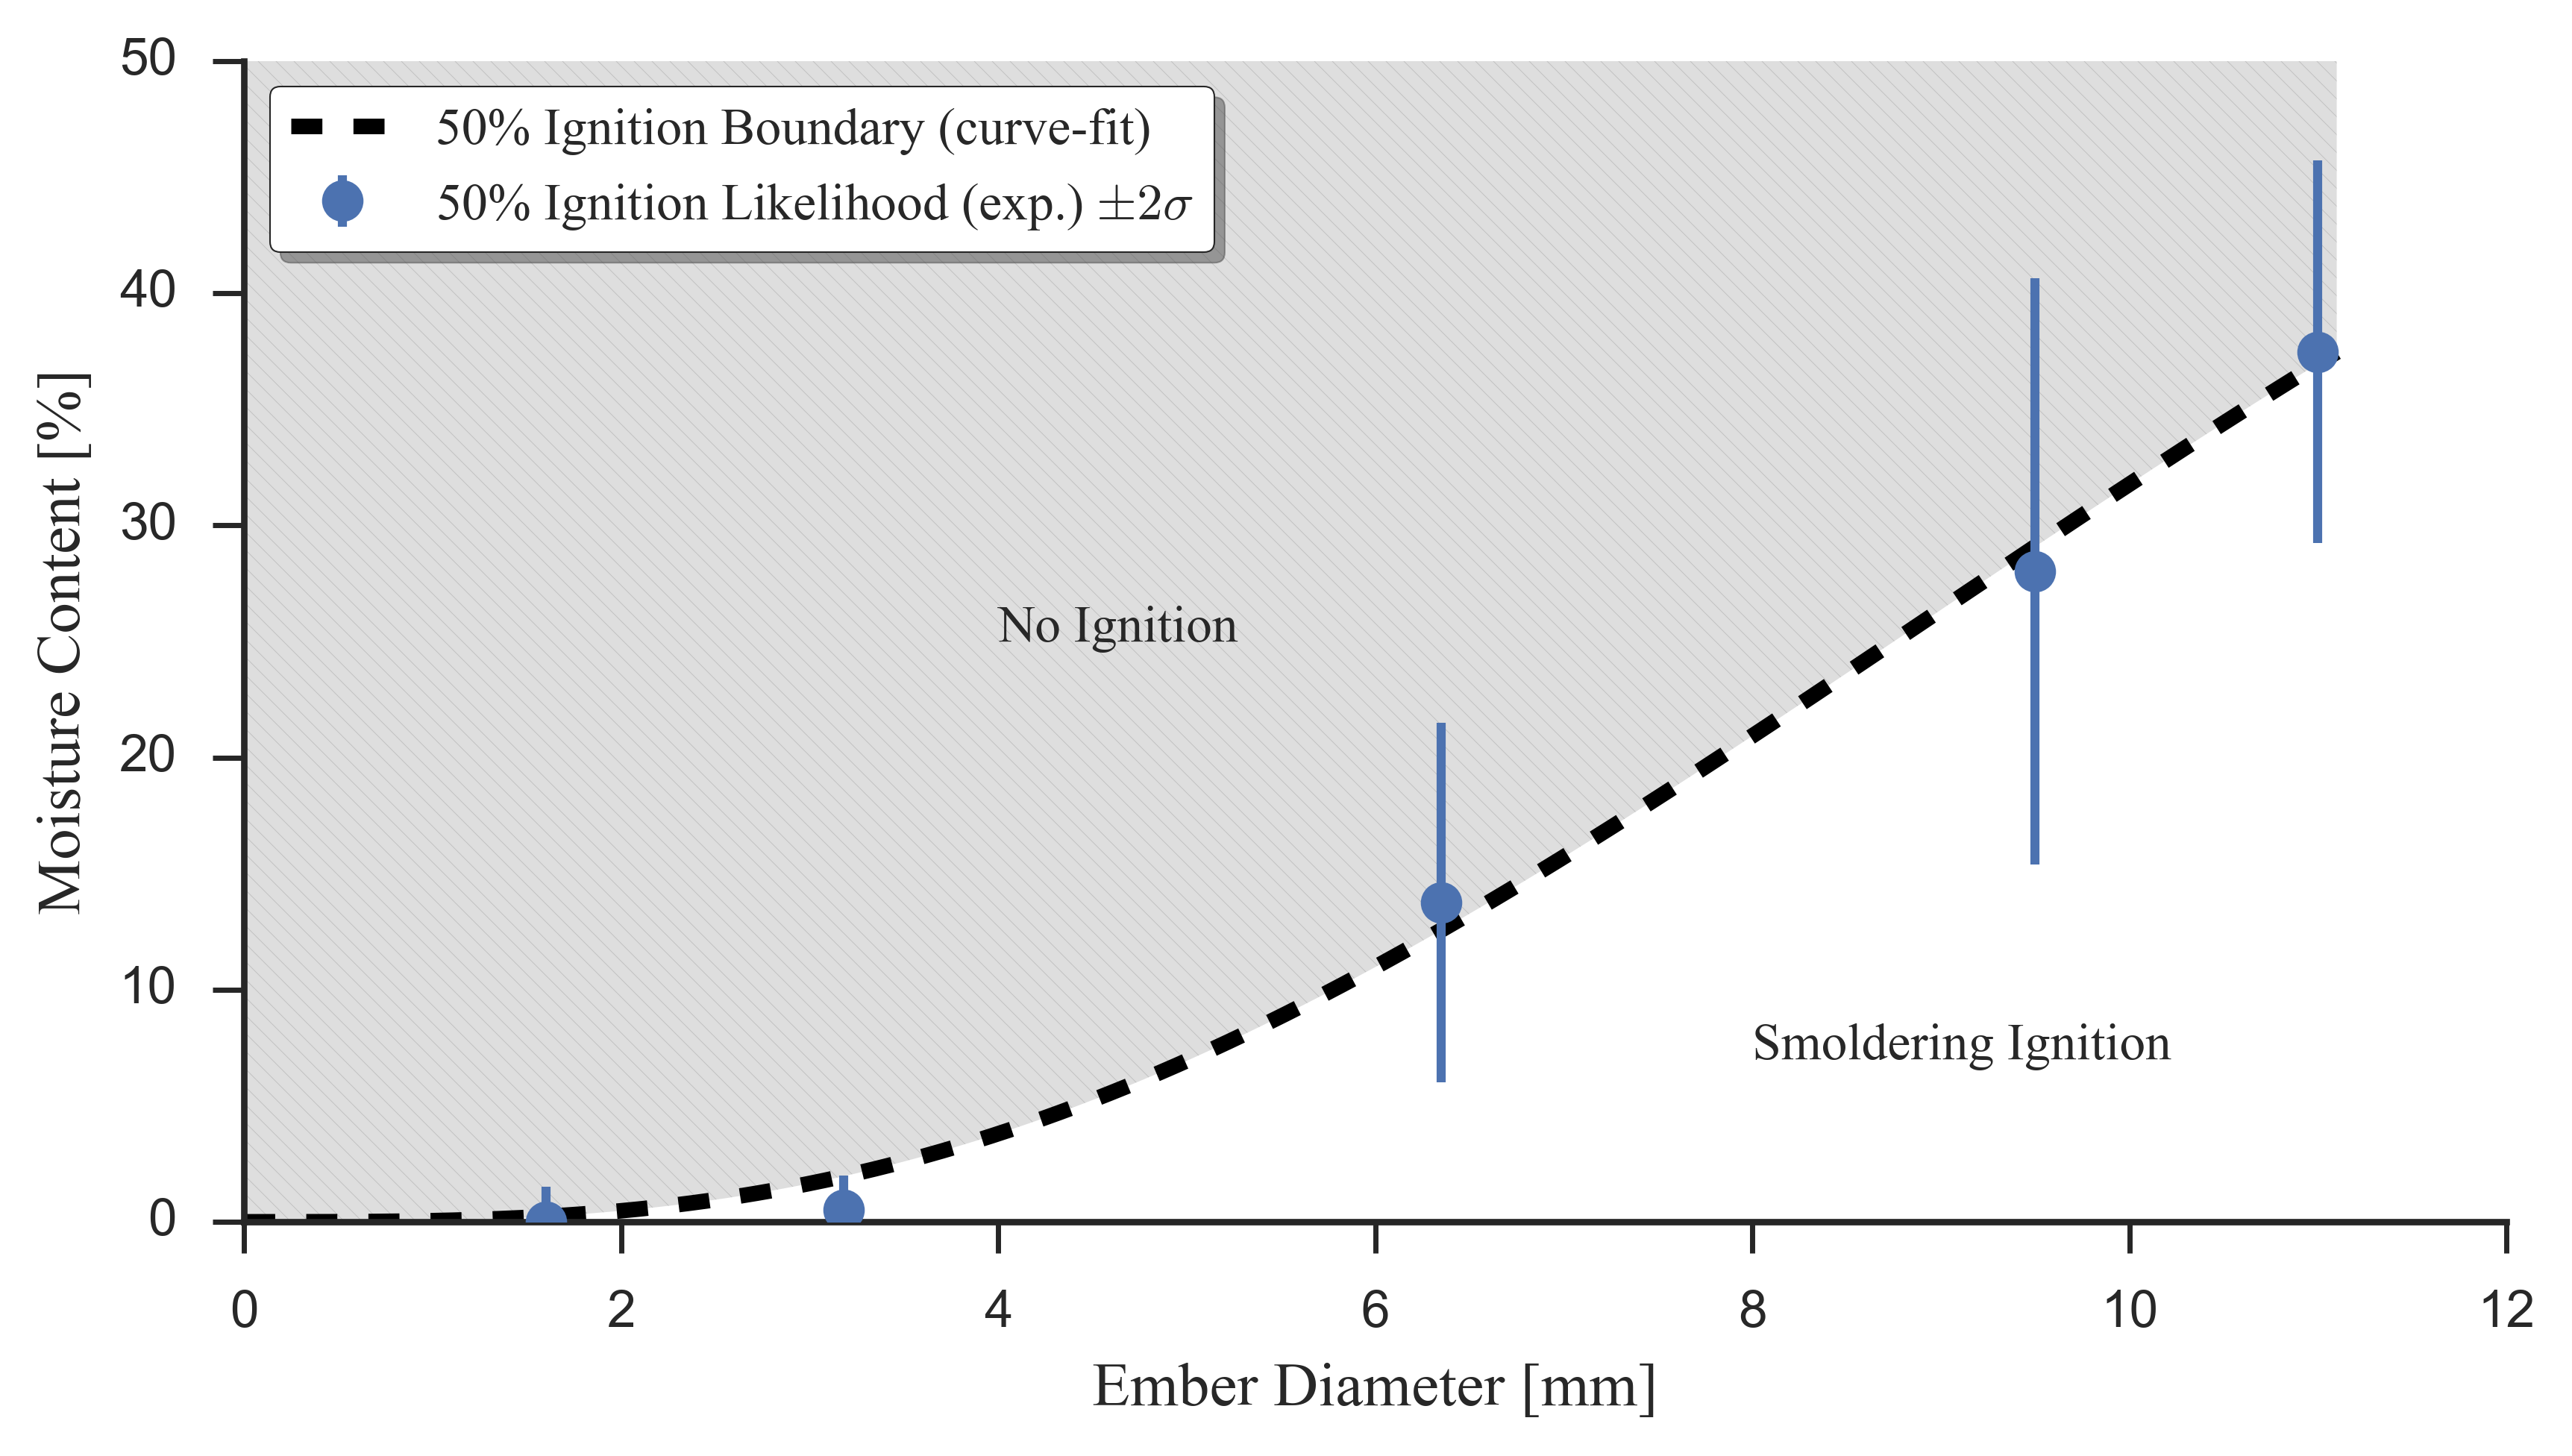

In [77]:
FS = 12
MS = 70
fig, ax = plt.subplots(ncols = 1)
sns.set_style("whitegrid", {'axes.grid' : False});   sns.set_style("ticks")
sns.despine()
# dp_arr = np.array([1.6,3.18,4.8,6.35,9.53,11.])
# MC_arr = np.array([0,.5,1.5,13.3,31.5,38])
# MC_arr= np.array([0,.5,1.5,13.3,28.5,38,])

Dp_plt2 = np.hstack((np.array([1.6,3.18]), Dp_plt[1:len(Dp_plt)-1]))
MC_plt2 = np.hstack((np.array([0,.005]), MC_plt[1:len(Dp_plt)-1]))
Error_plt2 = np.hstack((np.array([.015,.015]), Error_plt[1:len(Dp_plt)-1]))

# ax.scatter(Dp_plt2, MC_plt2*100.,s=MS,label='50% Ignition Likelihood')
ax.errorbar(Dp_plt2, MC_plt2*100,Error_plt2*100, fmt='o',label='50% Ignition Likelihood (exp.) $\pm 2 \sigma$',
            zorder = 99, markersize= 8)
# ax.set_xlim(0,13);  ax.set_ylim(0,50)
ax.set_xlabel("Ember Diameter [mm]",fontsize=FS,family = 'Serif')
ax.set_ylabel("Moisture Content [%]",fontsize=FS,family = 'Serif')
# ax.tick_params(axis='both', which='major', labelsize=13)

def func(x, a, b,c,d):
#     return a* /(1+np.exp(-b*x+c))
    return x**a*np.exp(-b*x+c)
#     return a*np.exp(b*x)*np.exp(c*x-d)
#     return d*x**3+a*x**2 + b*x + c
#     return a*np.sin(b*x+c)

parameter, covariance_matrix = curve_fit(func, Dp_plt2,MC_plt2*100.)
x = np.linspace(0, 11.1,1000)

ax.plot(x, func(x, *parameter), 'k--', linewidth=3,label='50% Ignition Boundary (curve-fit)')   # the star is to unpack the parameter array
ax.fill_between(np.hstack((x, 11.1)),
                np.hstack((func(x, *parameter), 50)),
                np.ones(len(x)+1)*50.,
                alpha = .13,hatch = '\\',facecolor = 'k',edgecolor = 'k', linewidth=0.0)

ax.set_ylim((0,50))
# ax.set_xlim((0,13))
# delta = .05*MC_plt2[-1]*100
# ax.fill_between(np.array([11.1,11.3]),
#                 np.ones(2)*MC_plt2[-1]*100+delta,
#                 np.ones(2)*MC_plt2[-1]*100-delta,
#                 alpha = 1,hatch = '\\',facecolor = 'w',edgecolor = 'k', linewidth=0.0)
# ax.plot(np.ones(2)*11.1,
#         MC_plt2[-1]*100*np.array([.95,1.05]),'k')

ax.text(8,7,'Smoldering Ignition',fontsize=FS-2,family = 'Serif')
ax.text(4,25,'No Ignition',fontsize=FS-2,family = 'Serif')
# ax.text(7.5,22,'50% Ignition Propability (curve-fit)',fontsize=FS-1)
plt.legend(loc=2,frameon=True,fancybox=True,shadow= True,prop={'family':"serif",'size':FS-2})
fig.set_size_inches((7,4));   fig.tight_layout(); plt.show()
fig.savefig("MC_boundary.png",dpi= 500)

C:\Users\urban\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


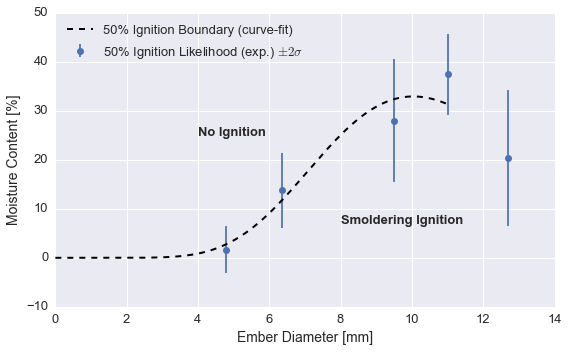

In [24]:
FS = 14
MS = 70
fig, ax = plt.subplots(ncols = 1)

dp_arr = np.array([1.6,3.18,4.8,6.35,9.53,11.])
MC_arr = np.array([0,.5,1.5,13.3,31.5,38])
# MC_arr = np.array([0,.5,1.5,13.3,28.5,38,])
# Error_plt = np.hstack((np.array([.015,.015]),Error_plt))

Dp_plt2 = np.hstack((np.array([1.6,3.18]),Dp_plt))
MC_plt2 = np.hstack((np.array([0,.005]),MC_plt))
Error_plt2 = np.hstack((np.array([.015,.015]),Error_plt))

# ax.scatter(Dp_plt2, MC_plt2*100.,s=MS,label='50% Ignition Likelihood')
ax.errorbar(Dp_plt, MC_plt*100,Error_plt*100, fmt='o',label='50% Ignition Likelihood (exp.) $\pm 2 \sigma$')
# ax.set_xlim(0,13);  ax.set_ylim(0,50)
ax.set_xlabel("Ember Diameter [mm]",fontsize=FS)
ax.set_ylabel("Moisture Content [%]",fontsize=FS)
ax.tick_params(axis='both', which='major', labelsize=13)

def func(x, a, b,c,d):
#     return a* /(1+np.exp(-b*x+c))
    return x**a*np.exp(-b*x+c)
#     return a*np.exp(b*x)*np.exp(c*x-d)
#     return d*x**3+a*x**2 + b*x + c
#     return a*np.sin(b*x+c)

parameter, covariance_matrix = curve_fit(func, Dp_plt2,MC_plt2*100.)
x = np.linspace(0, 11.1,1000)

ax.plot(x, func(x, *parameter), 'k--', linewidth=2,label='50% Ignition Boundary (curve-fit)')   # the star is to unpack the parameter array
ax.text(8,7,'Smoldering Ignition',fontsize=FS-1,fontweight='bold')
ax.text(4,25,'No Ignition',fontsize=FS-1,fontweight='bold')
# ax.text(7.5,22,'50% Ignition Propability (curve-fit)',fontsize=FS-1)
plt.legend(loc=2,fontsize=FS-1)
fig.set_size_inches((8,5));   fig.tight_layout(); plt.show()
fig.savefig("MC_boundary.png",dpi= 400)

In [122]:
# # import matplotlib.pyplot as plt
# # import numpy as np
# from numpy.random import normal
# from scipy.optimize import curve_fit

# x_data = np.linspace(0, 2*np.pi, 30)
# y_data = np.sin(x_data) + normal(0, 0.2, 30)


x = np.linspace(0, 11,1000)
plt.plot(x_data, y_data, 'rx', label='data')
plt.plot(x, func(x, *parameter), 'b-', label='fit')   # the star is to unpack the parameter array
plt.show()

NameError: name 'x_data' is not defined

In [14]:
RD.columns

Index(['PartMat', 'Fuel', 'HeatDur', 'WS', 'Diam', 'Length', 'MC', 'FBMass',
       'Result', 'Flags', 'ResBin'],
      dtype='object')

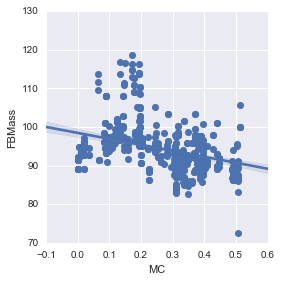

In [20]:
# fig, ax = plt.subplots(ncols=1)
ax = sns.lmplot(x="MC", y="FBMass", data=RD,
           palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1},)
ax.set_xlabels('Fuel Moisture Content []')